In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from time import time
from torchsummary import summary
import glob
import math
from sklearn.metrics import confusion_matrix

In [12]:
# HYPERPARAMETERS, for each hyperparameter corresponding value of commented for MyBest and MyBestSmall models
bs = 4 # Batch size, MyBest = MyBestSmall = 4
lr = 0.01 # Learning Rate, MyBest = MyBestSmall = 0.01
epochs = 54 # MyBest = 29, MyBestSmall = 54
seed = 0 # MyBest = MyBestSmall = 0
ts = 0.2 # Test size (train-validation split), MyBest = MyBestSmall = 0.2
numConvLayers = 4 # Number of convolution layers: 1, 2, 3, or 4 (CAN ONLY CHOOSE THESE VALUES), MyBest = MyBestSmall = 4
numKernels = 11 # Number of kernels, MyBest = 50, MyBestSmall = 11
FL_neurons = 60 # Number of neurons on first layer, MyBest = 16, MyBestSmall = 60
kernelSize = 3 # Kernel size, CAN ONLY BE 3 MyBest = MyBestSmall = 3
loss_fcn = "CEL" # Loss function: loss_fcn = "MSE" => mean square loss, loss_fcn = "CEL" - cross entropy loss, MyBest = MyBestSmall = "CEL"
act_fcn = F.relu # Activation function, only tested with ReLU but can change to torch.sigmoid or torch.tanh, MyBest = MyBestSmall = F.relu
torch.manual_seed(seed) 
batch_Norm = False # Set to true for batch normalization, set to false for no batch normalization, MyBest = MyBestSmall = False

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [4]:
def formDataSet(root):
    image_list = []
    for ID in classes:
        path = root+ID+'\\'
        for filename in glob.glob(path+'*.jpg'):
            im = plt.imread(filename)
            image_list.append(im)
    r = []
    g = []
    b = []
    for im in image_list:
        for x in range(0,56):
            for y in range(0,56):
                r += [im[x][y][0]]
                g += [im[x][y][1]]
                b += [im[x][y][2]]
    r_m = np.average(r).item()/255
    g_m = np.average(g).item()/255
    b_m = np.average(b).item()/255
    r_s = np.std(r).item()/255
    g_s = np.std(g).item()/255
    b_s = np.std(b).item()/255
    stats = [r_m, g_m, b_m, r_s, g_s, b_s]
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((r_m, g_m, b_m), (r_s, g_s, b_s))])
    images = torchvision.datasets.ImageFolder(root=root, transform=transform)
    return images, stats

In [5]:
def dispImages(images, stats):
    loader = data.DataLoader(images, batch_size=4, shuffle=True)
    dataiter = iter(loader)
    randBatch_imgs, randBatch_lbls = dataiter.next()
    randBatch_imgs[:,0:1,:,:] = randBatch_imgs[:,0:1,:,:]*stats[3] + stats[0]
    randBatch_imgs[:,1:2,:,:] = randBatch_imgs[:,1:2,:,:]*stats[4] + stats[1]
    randBatch_imgs[:,2:3,:,:] = randBatch_imgs[:,2:3,:,:]*stats[5] + stats[2]
    # Show images
    imshow(torchvision.utils.make_grid(randBatch_imgs))
    # Print labels
    print(' '.join('%5s' % classes[randBatch_lbls[j]] for j in range(4)))

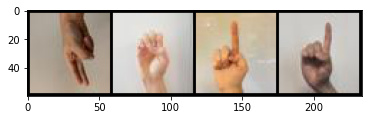

    H     E     D     D


In [6]:
# Get some random training images
classes = ('A','B','C','D','E','F','G','H','I','K')
img_data, img_stats = formDataSet('.\\training_v2\\training_v2\\')
dispImages(img_data, img_stats)

In [7]:
def stats(loader):
    n = 0
    mean = 0.0
    var = 0.0
    for img_t, _ in loader:
        img_t = img_t.view(img_t.shape[0], img_t.shape[1], -1)
        n += img_t.shape[0]
        mean += img_t.mean(2).sum(0) 
        var += img_t.var(2).sum(0)
    mean /= n
    var /= n
    std = torch.sqrt(var)
    return mean, std

In [8]:
train_img, test_img = train_test_split(
    img_data, test_size=ts, random_state=seed)
train_loader = data.DataLoader(dataset=train_img, batch_size=bs, shuffle=True)
test_loader = data.DataLoader(dataset=test_img, batch_size=bs)
print(len(test_img))
avg, stdev = stats(train_loader)
print("Mean: %s" % str(avg))
print("Standard Deviation: %s" % str(stdev))

763
Mean: tensor([-2.4770e-05, -3.3571e-03, -5.8319e-03])
Standard Deviation: tensor([0.8382, 0.8882, 0.8758])


In [9]:
le = LabelEncoder()
le_classes = le.fit_transform(classes)
enc = OneHotEncoder()
enc_classes = enc.fit_transform(le_classes.reshape(-1,1)).toarray()

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,numKernels,kernelSize)
        self.conv2 = nn.Conv2d(numKernels,numKernels,kernelSize)
        self.conv_BN = nn.BatchNorm2d(numKernels)
        self.pool = nn.MaxPool2d(2,2)
        self.input_dim = 1
        if numConvLayers==1:
            self.input_dim = 27
        elif numConvLayers==2:
            self.input_dim = 12
        elif numConvLayers==3:
            self.input_dim = 5
        self.fc1 = nn.Linear(numKernels*self.input_dim*self.input_dim,FL_neurons)
        self.fc2 = nn.Linear(FL_neurons,10)
        self.fc1_BN = nn.BatchNorm1d(FL_neurons)
    def forward(self,x):
        if batch_Norm == True:
            x = self.pool(act_fcn(self.conv_BN(self.conv1(x))))
            if (numConvLayers==2) or (numConvLayers==3) or (numConvLayers==4):
                x = self.pool(act_fcn(self.conv_BN(self.conv2(x))))
                if (numConvLayers==3) or (numConvLayers == 4):
                    x = self.pool(act_fcn(self.conv_BN(self.conv2(x))))
                    if numConvLayers==4:
                        x = self.pool(act_fcn(self.conv_BN(self.conv2(x))))
        else:
            x = self.pool(act_fcn(self.conv1(x)))
            if (numConvLayers==2) or (numConvLayers==3) or (numConvLayers==4):
                x = self.pool(act_fcn(self.conv2(x)))
                if (numConvLayers==3) or (numConvLayers==4):
                    x = self.pool(act_fcn(self.conv2(x)))
                    if numConvLayers==4:
                        x = self.pool(act_fcn(self.conv2(x)))        
        x = x.view(-1,numKernels*self.input_dim*self.input_dim)
        if batch_Norm == True:
            x = act_fcn(self.fc1_BN(self.fc1(x)))
            x = self.fc2(x)
        else:
            x = act_fcn(self.fc1(x))
            x = self.fc2(x)
        return x

In [11]:
def accuracy(model,loader):
    corr = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            corr += (predicted == labels).sum().item()
    return corr/total

In [12]:
def convert_Label(output):
    i, label = torch.max(output.data, 1)
    return label

In [13]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr) 
loss_t = []
acc_t = []
loss_v = []
acc_v = []
start = time()
for e in range(epochs):
    print("Epoch: %d" % (e+1))
    running_loss = 0
    batches = 0
    for i, (t_inputs, t_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        t_predict = model(t_inputs.float())
        if loss_fcn == "MSE":
            criterion = nn.MSELoss() 
            t_labels = torch.Tensor(enc_classes[t_labels])
        elif loss_fcn == "CEL":
            criterion = nn.CrossEntropyLoss()
        t_loss = criterion(t_predict,t_labels)
        t_loss.backward()
        optimizer.step()
        running_loss += t_loss.item()
        batches+=1
    t_acc = accuracy(model,train_loader)
    v_acc = accuracy(model,test_loader)
    acc_t.append(t_acc)
    acc_v.append(v_acc)
    loss_t.append(running_loss/batches)
    running_loss = 0
    batches = 0
    for i, (v_inputs, v_labels) in enumerate(test_loader):
        v_predict = model(v_inputs.float())
        if loss_fcn == "MSE":
            v_labels = torch.Tensor(enc_classes[v_labels])
        v_loss = criterion(v_predict,v_labels)
        running_loss += v_loss.item()
        batches += 1
    loss_v.append(running_loss/batches)
end = time()-start
print("Validation Accuracy %f" % acc_v[-1])

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Validation Accuracy 0.913499


In [13]:
# torch.save(model.state_dict(), 'MyBest.pt')
# torch.save(model.state_dict(), 'MyBestSmall.pt')
# BestModel = Net()
# BestModel.load_state_dict(torch.load("./MyBest.pt")) 
# torch.save(BestModel,"fullbestmodel.pt2")
SmallModel = Net()
SmallModel.load_state_dict(torch.load("./MyBestSmall.pt")) 
torch.save(SmallModel,"fullsmallestbestmodel.pt2")

In [15]:
test_pred = []
test_labels = []
for i, (v_inputs, v_labels) in enumerate(test_loader):
    v_predict = model(v_inputs.float())
    test_pred.append(convert_Label(v_predict).tolist())
    test_labels.append(v_labels.tolist())
flat = lambda arr: [item for sublist in arr for item in sublist]
print(confusion_matrix(flat(test_pred),flat(test_labels)))

[[73  0  0  1  4  2  1  1  0  0]
 [ 0 86  0  0  1  1  1  0  1  1]
 [ 1  0 63  0  0  0  0  0  0  0]
 [ 0  0  1 69  0  0  0  1  1  4]
 [ 7  2  0  1 53  0  0  0  0  0]
 [ 1  2  0  1  0 65  0  1  0  0]
 [ 0  0  0  7  0  0 73  3  0  0]
 [ 0  2  0  2  0  0  4 76  0  3]
 [ 1  0  0  1  0  1  1  0 73  0]
 [ 0  1  0  3  0  0  0  0  0 66]]


In [16]:
print("Time: %f" % end)
summary(model, input_size=(3, 56, 56))

Time: 884.871277
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 54, 54]             896
         MaxPool2d-2           [-1, 32, 27, 27]               0
            Conv2d-3           [-1, 32, 25, 25]           9,248
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5           [-1, 32, 10, 10]           9,248
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 32, 3, 3]           9,248
         MaxPool2d-8             [-1, 32, 1, 1]               0
            Linear-9                   [-1, 32]           1,056
           Linear-10                   [-1, 10]             330
Total params: 30,026
Trainable params: 30,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 1.11
Params size (MB): 0

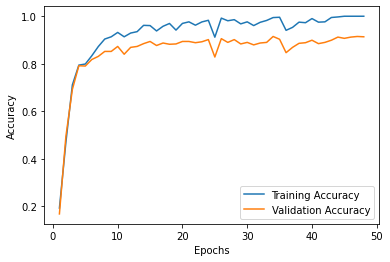

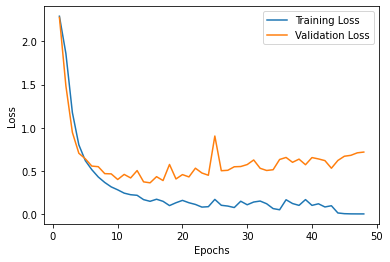

In [17]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(list(range(1,epochs+1)),acc_t,label="Training Accuracy")
plt.plot(list(range(1,epochs+1)),acc_v,label="Validation Accuracy")
plt.legend()
plt.show()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(list(range(1,epochs+1)),loss_t,label="Training Loss")
plt.plot(list(range(1,epochs+1)),loss_v,label="Validation Loss")
plt.legend()
plt.show()